<a href="https://colab.research.google.com/github/stefanocostantini/pytorch-book/blob/master/ch7_learning_from_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data

We use CIFAR-10. CIFAR-10 consists of 60,000 tiny 32 × 32 color (RGB) images, labeled with an integer corresponding to 1 of 10 classes: airplane (0), automobile (1), bird (2), cat (3), deer (4), dog (5), frog (6), horse (7), ship (8), and truck (9).

We use the `torchvision` module to automatically download the dataset as a collection of PyTorch tensors.

In [1]:
import torch

In [2]:
## Download files locally
!mkdir /content/cifar10/
from torchvision import datasets
data_path_for_saving = '/content/cifar10/'
cifar10 = datasets.CIFAR10(data_path_for_saving, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path_for_saving, train=False, download=True)

Extracting /content/cifar10/cifar-10-python.tar.gz to /content/cifar10/
Files already downloaded and verified


The dataset is returned as a subclass of `torch.utils.data.Dataset`. But what does this mean in practice?


### Dataset class

The `Dataset` is an object which implements two methods: `__len__` and `__getitem__`. The former gives us the length of the dataset, while the latter gives us the item (sample and corresponding label)

This means we can do the following:


In [3]:
# How many items?
len(cifar10)

50000

In [4]:
# Show me item 100
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 
               'horse', 'truck']
item, label = cifar10[99]
item, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7FD63F239400>,
 1,
 'automobile')

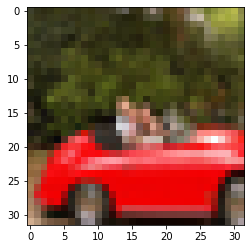

In [5]:
from matplotlib import pyplot as plt
plt.imshow(item)
plt.show()

## Dataset transforms

We need to convert the image into a PyTorch tensor before it can be us. 

For this, we use the `torchvision.transforms` module, which defines a set of composable, function-like objects that can be passed as an argument to a `torchvision` dataset like `datasets.CIFAR10`

These transformations are done to the data after it is loaded, but before it is returned by `__getitem__`

In [6]:
from torchvision import transforms
dir(transforms)

['CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'Grayscale',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandomAffine',
 'RandomApply',
 'RandomChoice',
 'RandomCrop',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomOrder',
 'RandomPerspective',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In this case, were are interested in `ToTensor` which converts numpy arrays and PIL images to tensors with dimensions `C x H x W` (channels, height and width). So for example:

In [7]:
to_tensor = transforms.ToTensor()
item_t = to_tensor(item)
item_t.shape

torch.Size([3, 32, 32])

Let's now do this for the whole dataset

In [8]:
tensor_cifar10 = datasets.CIFAR10(data_path_for_saving, train=True, download=False,
                                  transform=transforms.ToTensor())
tensor_cifar10_val = datasets.CIFAR10(data_path_for_saving, train=False, download=False,
                                      transform=transforms.ToTensor())

In [9]:
# We now get the tensor instead of the image
item_t, _ = tensor_cifar10[99]
type(item_t)

torch.Tensor

In [10]:
item_t.shape, item_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

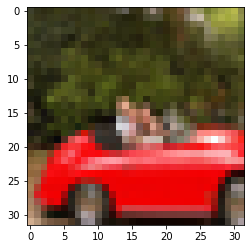

In [11]:
# Let's print it now, bearing in mind that matplotlib need height and width first,
# and the number of channels later
plt.imshow(item_t.permute(1,2,0))
plt.show()

In addition to converting the images arrays to tensors, another useful transformation to apply is a **normalisation**, to ensure all values are within similar ranges (subtract mean and divide by standard deviation)_ 

For this, we can use the `Normalize` transform, but we need to know the means and standard deviations of the three channels. We do this below, then applying it to obtain a normalised dataset of tensor.

In [12]:
# First we put all the photos together into the same stack. The resulting tensor
# will have 3 * 32 * 32 * 50000 dimensions.
imgs = torch.stack([item_t for itema_t, _ in tensor_cifar10], dim = 3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [13]:
# We now want to calculate mean and st. dev for the colour channels. 
# Then we need to change the dimensions of the tensor. In this case, we want
# to keep the information for the three channels, but we want to combine the remaining
# information into a single dimension.
reshaped = imgs.view(3,-1) # keep the first dimension, squash all others into a single dim
print(reshaped.shape)

means = reshaped.mean(dim=1) # mean of the first dimension (i.e. the three channels)
stds = reshaped.std(dim=1) # std of the first dimension (i.e. the three channel)
means, stds

torch.Size([3, 51200000])


(tensor([0.4608, 0.2484, 0.1617]), tensor([0.3043, 0.1605, 0.1529]))

In [14]:
# Now we have the information to do the normalisation, as follows.
# Note that we `compose` transformations together
transformed_cifar10 = datasets.CIFAR10(data_path_for_saving, train=True, download=False,
                                       transform = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((means[0], means[1], means[2]),
                                                              (stds[0], stds[1], stds[2]))                              
                                       ]))

transformed_cifar10_val = datasets.CIFAR10(data_path_for_saving, train=False, download=False,
                                       transform = transforms.Compose([
                                         transforms.ToTensor(),
                                         transforms.Normalize((means[0], means[1], means[2]),
                                                              (stds[0], stds[1], stds[2]))                              
                                       ]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


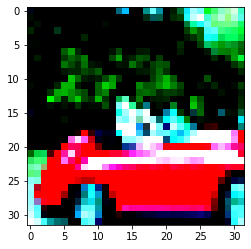

In [15]:
# We can now plot again the same image to see how it looks like after normalisation
# (remember we need to change the order of the dimensions)
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1,2,0))
plt.show()

Looks like some information might have been lost, but apparently this is just a artifact of how matplotlib interprets the information. All the original information will be there, just normalised.

## Model

## Prepare the data

We could create a subclass of `torch.utils.data.Dataset` but in this case the dataset is simpler (though this should be tried at some point). 

Basically from Cifar10, we want to keep only two classes: birds and airplanes. At the moment these classes have labels 0 and 2, we want to re-labels them to 0 and 1.

In [16]:
# We have these classes
transformed_cifar10.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [17]:
# We just want to keep class 0 and 2. Remember that the __getitem__ method returns
# both the item and its label
class_mapping = {0: 0, 2: 1}

cifar2 = [(item, class_mapping[label])
          for item, label in tensor_cifar10 if label in [0,2]]
cifar2_val = [(item, class_mapping[label])
          for item, label in tensor_cifar10_val if label in [0,2]] 

In [18]:
# And here are the datasets we need
print(len(cifar2), len(cifar2_val))

10000 2000


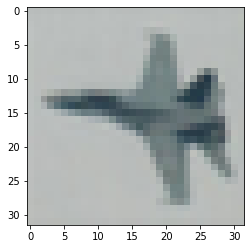

0


In [19]:
# We have a plane...
plt.imshow(cifar2[132][0].permute(1,2,0))
plt.show()
print(cifar2[132][1]) #label

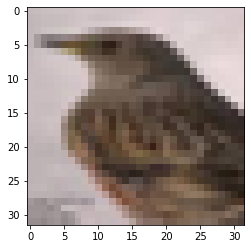

1


In [20]:
# ...and we have a bird
plt.imshow(cifar2[2][0].permute(1,2,0))
plt.show()
print(cifar2[2][1]) #label

### Model setup

To keep things simple for now, we will process data in 1D. This means that our images with dimensions 3 x 32 x 32, will need to be turned into a 1D tensor with 3072 dimensions. 

So the model will have a first linear module with 3072 input features, and (arbitrarily) 512 output features. We will add an activation function (`tanh`) in between, to make the model non-linear. 

We will then have an output layer with has 512 input features. Instead of making it output just one feature, as we would do in a regression problem, we want to get out the respective probabilities of the two classes. We will set the numbers of output features to 2.

This means that we would like to have tensors like `tensor([1.0, 0.0])` for airplanes and `tensor([0.0, 1.0])` for birds. In order to get probabilities out, we apply a `softmax` transformation to the output.

Here's the model:

In [21]:
from torch import nn
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.Softmax(dim=1))

In [22]:
# As an aside, why dim=1 for the softmax? Because dim=0 would indicate the batch,
# so for example, if we want to softmax each item
x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

print(x.shape)

softmax = nn.Softmax(dim=1)
softmax(x)

torch.Size([2, 3])


tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

Now that we have the model, let's try to feed it one image to see what we get out. This is not trained, but we can check the extent to which the output looks like what we need.


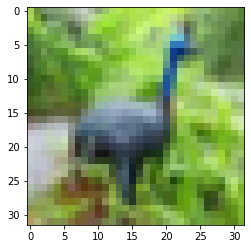

In [23]:
# First change the dimensions of the image (3 x 32 x 32 = 3072), 
# adding the batch number in position 0
test_image, _ = cifar2[0]
plt.imshow(test_image.permute(1,2,0))
plt.show()

In [24]:
# We use view to squeeze all dimensions into a single one (with -1) and then we
# add the batch dimension
test_image_reshaped = test_image.view(-1).unsqueeze(0)
print(test_image_reshaped.shape)

torch.Size([1, 3072])


In [25]:
# And now we can run it through the model
output = model(test_image_reshaped)
print(output)

tensor([[0.4997, 0.5003]], grad_fn=<SoftmaxBackward>)


In [26]:
# They look like proper probabilities and we can actually choose the class by
# applying an argmax function on the output
classes = ['airplane', 'bird']
_ , index = torch.max(output, dim=1)
predicted_label = classes[index]
print(predicted_label)

bird


It got it right, but this is just luck as the model has not been trained. Before we do that, we need to specify a loss for this classification problem.

### Loss function

In the case of classification, what we need to maximize in this case is the probability associated with the correct class, i.e. `out[class_index]` where `out` is the output of softmax and `class_index` is a vector containing 0 for _airplane_ and 1 for _bird_. 

The probability of each class is referred to as the _likelihood_. In this case we can use the `negative log likelihood (NLL)`, with the expression `NLL = -sum(log(out_i[c_i])`, where the sum is taken over `N` samples and `c_i` is the correct class for sample `i`.

This loss is available in pytorch as `nn.NLLloss`. It takes as input the log of the softmax (for numerical stability reasons) so we need to modify the model accordingly.

Here's how we get the output for a class and calculate the loss.

In [27]:
# Modified model
model=nn.Sequential(
    nn.Linear(3072,512),
    nn.Tanh(),
    nn.Linear(512,2),
    nn.LogSoftmax(dim=1)
)

In [28]:
# Get image and label from dataset
img, label = cifar2[0]
print(label)

# Define loss
loss = nn.NLLLoss()

# Calculate model output
out = model(img.view(-1).unsqueeze(0))

# Calculate loss
loss(out, torch.tensor([label]))

1


tensor(0.8519, grad_fn=<NllLossBackward>)

### Training the model (DataLoader for minibatches)

Let's write a training loop as we had in previous chapters:

In [29]:
def training(n_epochs, model, loss_fn, optimizer, dataset):
  for epoch in range(n_epochs):
    for img, label in dataset:
      out = model(img.view(-1).unsqueeze(0)) # calculate model output
      loss = loss_fn(out, torch.tensor([label])) # calculate loss

      optimizer.zero_grad() # reset gradient
      loss.backward() # backprop
      optimizer.step() # update parameters
    print(f'Epoch: {epoch} / Loss: {loss}') # print the value of the loss at the end of the epoch

In [30]:
import torch.optim as optim
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
training(100, model, loss, optimizer, cifar2)

Note the difference here between what we did in the previous chapter and now. 

Before, we were looking at all samples in each epoch and calculating the gradient - and the updates to the parameters - based on that. 

In this case, to avoid considering all 10,000 images at ones, we evaluate the gradient after each image and update the parameters accordingly. But choosing the best update to the parameters based on just one image is not necessarily very helpful (you can see that the loss is not really going down)

Much better to shuffle samples at each epoch and estimating the gradient on a small set of them at a time (minibatch). This will actually introduce the randomness needed for the _stochastic gradient descent_ optimisation. The size of the minibatch is one other `hyperparameters` of the model, like the learning rate.

Essentially, in our code above our minibatches were of size 1. We want to increase that, and be able to sample them from the dataset. To do this, we use `torch.utils.data.DataLoader`. This can be iterated over, so we can minimally change our training loop as follows:

In [32]:
from torch.utils.data import DataLoader

def training_batch(n_epochs, model, loss_fn, optimizer, dataset, batch_size): # passing the batch size
  loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True) # define the DataLoader
  for epoch in range(n_epochs):
    for imgs, labels in loader: # each time from the loader we get 64 images and labels
      batch_size = imgs.shape[0]
      outputs = model(imgs.view(batch_size, -1)) # calculate model output - no longer need to add batch dimension, as we're using loader
      loss = loss_fn(outputs, labels) # calculate loss

      optimizer.zero_grad() # reset gradient
      loss.backward() # backprop
      optimizer.step() # update parameters
    print(f'Epoch: {epoch} / Loss: {loss}') # print the value of the loss at the end of the epoch (for a random batch for now)

In [33]:
from torch import nn

# Define model
model=nn.Sequential(
    nn.Linear(3072,512),
    nn.Tanh(),
    nn.Linear(512,2),
    nn.LogSoftmax(dim=1)
)

# Define the loss
loss = nn.NLLLoss()

In [34]:
# define the optimizer
import torch.optim as optim
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [35]:
# We can now train the model, specifying the batch size. Now each batch will be 
# tensor of dimensions 64 x 3 x 32 x 32
training_batch(50, model, loss, optimizer, cifar2, 64)

Epoch: 0 / Loss: 0.47132188081741333
Epoch: 1 / Loss: 0.6545965075492859
Epoch: 2 / Loss: 0.5176128149032593
Epoch: 3 / Loss: 0.473799467086792
Epoch: 4 / Loss: 0.44869789481163025
Epoch: 5 / Loss: 0.6133908629417419
Epoch: 6 / Loss: 0.3686857521533966
Epoch: 7 / Loss: 0.4071042239665985
Epoch: 8 / Loss: 0.27685293555259705
Epoch: 9 / Loss: 0.5454249978065491
Epoch: 10 / Loss: 0.6575824022293091
Epoch: 11 / Loss: 0.43090367317199707
Epoch: 12 / Loss: 0.47585201263427734
Epoch: 13 / Loss: 0.7135488986968994
Epoch: 14 / Loss: 0.5646320581436157
Epoch: 15 / Loss: 0.44474223256111145
Epoch: 16 / Loss: 0.7537976503372192
Epoch: 17 / Loss: 0.29252123832702637
Epoch: 18 / Loss: 0.4682617783546448
Epoch: 19 / Loss: 0.3697270154953003
Epoch: 20 / Loss: 0.28341689705848694
Epoch: 21 / Loss: 0.19836565852165222
Epoch: 22 / Loss: 0.3803112804889679
Epoch: 23 / Loss: 0.3855658769607544
Epoch: 24 / Loss: 0.4814615547657013
Epoch: 25 / Loss: 0.4082076847553253
Epoch: 26 / Loss: 0.2415146380662918
Epo

We note that the model also trains faster as we're not calculating the backprop and update the parameters at each image. 

The performance is still poor though, and the loss doesn't really go down. It's the training loss, which suggests that the model doesn't have the required `capacity` to approximate the function.

We can check the accuracy of the model by calculating it on the validation dataset

In [36]:
# define validation loader
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
  for imgs, labels in val_loader:
    batch_size = imgs.shape[0]
    outputs = model(imgs.view(batch_size, -1))
    _, predicted = torch.max(outputs, dim=1)
    total += labels.shape[0]
    correct += int((predicted == label).sum())

print(f'Accuracy: {correct / total}')


Accuracy: 0.769


The validation accuracy is not great. This may be due to the model overfitting the data. Already this model has quite a lot of parameters, which might make it easier for the model to overfit. We can check the number of trainable parameters as follows:

In [41]:
numel_list = [p.numel()
              for p in model.parameters()
              if p.requires_grad == True]

print(sum(numel_list), numel_list)

1574402 [1572864, 512, 1024, 2]


What is the problem here? The key thing is that we're treating images as a single 1D vector where all connections of each pixel with any other pixel are potentially equally important. 

Moreover, this approach is not _translation invariant_. So, if the model learned to recognise a bird in the top left corner, it would not be able to recognised a bird just shifted a few pixel to the right. We could introduce all these images doing data augmentation but we would still be using a lot of model capacity to try to learn from all examples. 

We need to shift to a method which is no longer fully connected, and that it's able to recognise similar patterns of pixels independently of where they occur, i.e. we need convolutional layers.